In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import napari
from FoodSeg103_data_handler import *

## Create scribbles

Load the ground truths as batch

In [85]:
img_nums = [3510]#[n for n in range(0, 4900, 130)] #[1382] #2750 #1234 #2314
gts = load_food_batch(img_nums, load_images=False)[1]
num_imgs = len(gts)
print(f"Total images: {num_imgs}")

Total images: 1


Check and filter for resolution

In [ ]:
resol = {im_num: np.prod(gt.shape) for im_num, gt in gts.items()}

# Check for images with resolution over a certain threshold
thresh = 250_000
print("Resolutions:")
for im_num, r in resol.items(): print(f"{im_num:4d}: {r:9,d} pixels{' (!)' if r > thresh else ''}")

In [ ]:
# Filter out those images
gts = {im_num: gt for im_num, gt in gts.items() if resol[im_num] <= thresh}
num_imgs = len(gts)
print(f"Images with resolution under {thresh:,d}: {num_imgs}")
resol_new = {im_num: np.prod(gt.shape) for im_num, gt in gts.items()}
for im_num, r in resol_new.items(): print(f"{im_num:4d}: {r:7,d} pixels")

Define scribbles parameters

In [24]:
# Which scribbles to create
mode = "all"
class_dist = "balanced"
enforce_max_perc = True
# bin_width = [(0.05, 1), (0.1, 1),
            #  (0.25, 2), (0.5, 2), (1, 2),
            #  (2.5, 3), (5, 3),
            #  (10, 4)]
bins = [0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 1, 2.5, 5, 10] #[0.01, 0.03, 0.1, 0.3, 1, 3, 10]#[0.05, 0.25, 1, 5]
margin = 0.75
scribble_width = 2
# suff = ["TEST"] #["w3"] #standing for width 3
s = "TEST"
rel_scribble_len = 10
scribbles_seed = 1

# Where to save the scribbles
folder_path = "./FoodSeg103_results/data/food_run02"

# What to do
save_res = False
show_res = True
print_steps = True

Loop and create scribbles

In [84]:
percentages = {}
for bin in bins:
# for bin, scribble_width in bin_width:
    percentages[bin] = []
    for img_num, gt in gts.items():
        print(f"IMG {img_num}: bin {bin}, suff {s}")
        np.random.seed(scribbles_seed)
        scribbles, perc_labelled = create_food_scribble(gt, folder_path, img_num, bin=bin, margin=margin, rel_scribble_len=rel_scribble_len, scribble_width=scribble_width, mode=mode,
                                                        class_dist=class_dist, enforce_max_perc=enforce_max_perc,
                                                        save_res=save_res, suff=s, show_res=show_res, image=None, print_steps=print_steps)
        percentages[bin].append(perc_labelled)
        print("\n")

IMG 0: bin 0.01, suff TEST

max. perc.: 0.01, margin: 0.75, rel_scribble_len: 10.00, width: 2, mode: all, class_dist: balanced, enforce_max_perc: True, print_steps: True

CLASS 1, max. pixel: 0.010% = 4 pixels
   sk_max_pix: 4.00, sq_size: 44, sq_pix_range: (4, 176)
         Adjusting square size and range to 23 (2, 176)
         Sampling skeleton squares - sk_max_pix_left: 4
         Adjusting square size and range to 12 (1, 176)
         Sampling skeleton squares - sk_max_pix_left: 4
         Adjusting square size and range to 7 (1, 176)
         Sampling skeleton squares - sk_max_pix_left: 4
         Adjusting square size and range to 4 (1, 176)
         Sampling skeleton squares - sk_max_pix_left: 4
      prim_sk_squares pix: 4 = 0.008%
         Adjusting square size and range to 23 (2, 176)
         Sampling skeleton squares - sk_max_pix_left: 4
         Adjusting square size and range to 12 (1, 176)
         Sampling skeleton squares - sk_max_pix_left: 4
         Adjusting square

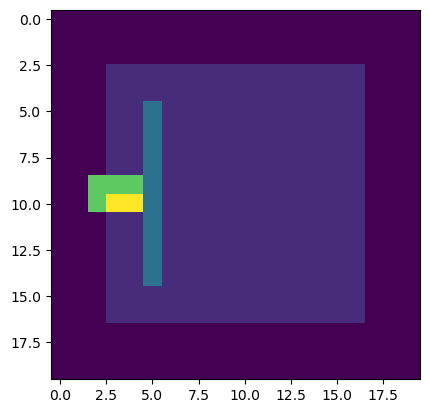

In [83]:
from skimage.morphology import *
from matplotlib import pyplot as plt
from scribbles_creator import *

dil = 2
mask = np.zeros((20,20))
mask[3:17, 3:17] = 1

sk_single = np.zeros((20,20))
sk_single[5:15, 5] = 1

sk_dil = binary_dilation(img, footprint=square(dil))

line_single = get_line([10,5], mask, line_crop=2)

line_dil = binary_dilation(line_single, square(dil))

sq = get_square(sk_dil, (5,5), 2)
im_show = np.zeros((20,20))
im_show[mask==1] = 1
# im_show[sk_dil==1] = 2
im_show[sk_single==1] = 3
# im_show[sq] = 5
im_show[line_dil==1] = 6
im_show[line_single==1] = 8

plt.imshow(im_show)

Quick report of labelling percentages:

In [ ]:
for bin, perc_list in percentages.items():
    print(f"labelled percentage in bin {bin}: mean = {np.mean(perc_list):.4f}, std = {np.std(perc_list):.4f}, range = {np.min(perc_list):.4f} - {np.max(perc_list):.4f}")

Check percentages of saved scribbles

In [ ]:
perc_dict = {}
for bin in bins:
    bin_perc_list = []
    for img_num in range(0,540,20):
        scrib = np.array(Image.open(f"{folder_path}{img_num:03d}_scribbles_{mode}_{bin_for_file(bin)}_{s}.png"))
        perc_labelled = np.sum(scrib > 0) / scrib.size
        bin_perc_list.append(perc_labelled)
    perc_dict[bin] = bin_perc_list

Show the last created scribble with its own ground truth, and (optionally) all other ground truths

In [ ]:
v = napari.Viewer()
v.add_labels(gt, name="Ground Truth")
v.add_labels(scribbles, name="Scribbles")

In [ ]:
for g in gts:
    v.add_labels(gts[g], name=f"GT {g}")